### $\color{indianred}{\text{ЧЕТВРТА ВЈЕЖБА ИЗ АСТРОСТАТИСТИКЕ}} $

### Фреквентистичко & бајесовско закључивање

<hr style="border: none; height: 2px; background-color: red; opacity: 0.5;" />

Фреквентистички и бајесовски приступ статистици су различити што се тиче интерпретације

вјероватноће и узорковања. У фреквентистичкој филозофији, претпоставка је да је истинита

вриједност неког параметра фиксна, али подаци осцилирају око те вриједности због случајног

узорковања и сл. Вјероватноћа, узевши ово у обзир, има смисла само за велики број понављања.

Бајесовска статистика третира неки параметре као случајне варијабле, које се могу описати

расподјелом вјероватноће. Овдје је омогућено укључивање претходних знања/информација, па 

је самим тим могуће и унаприједити статистички опис, добијањем нових података. Разлику између

приступа (Ф и Б) можемо описати сљедећом реченицом: Ф не може рећи нешто попут "постоји 

вјероватноћа (рецимо 99%) да параметар припада неком интервалу вриједности", већ Ф гарантује 

да 99% свих креираних интервала (на неки специфичан начин) садржи истиниту вриједност. Б ће 

пак, рећи да постоји 99% шансе да је параметар садржан у интервалу (интуитивнији приступ).

---

ПРИМЈЕР: за фреквентисту, најбоља процјена је просјек многих резултата испита. Дакле, ако

особа полаже испит 10 пута и добије узорковани просјек од 25, то би била процјена знања.

Са друге стране, бајесовски, особа је довољно учила да би постигла просјечни скор 26 уз

стандардну девијацију од 2 поена. Она ће користити ту информацију као $\text{prior}$, те је

добијање резултата 30 еквивалентно одступању од просјека за 2 стандардна отклањања (нпр.

срећно питање), а неполагање испита (резултат мањи од 18) је изузетно мало вјероватан.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats
from scipy import optimize
from scipy.stats import norm
from scipy.stats import uniform
from scipy.stats import poisson
from astroML import stats as astroMLstats
from astroML.datasets import fetch_hogg2010test
from astroML.resample import bootstrap
from astroML.stats import sigmaG
from astroML.resample import jackknife

IQ неке популације има средњу вриједност 100 и стандардну девијацију од 15. Ако особа ради тест

и добије резултат од 160, да ли је то заправо у реду? Бајесовском анализом се може извести сљедеће:

$$
p(141.3\leq\mu\leq154.7\,|\,\overline{x}=160)=0.683,
$$

што у суштини показује да је средња вриједност резултата теста, за људе које добију резултат 160,

доста нижа, и износи 148 (важи: $148\pm6.7$). Ово сугерише да је реалан IQ вјероватно нижи од оног 

добијеног на тесту, због утицаја претходног знања да већина људи има IQ ближи 100. Резултат теста 

није апсолутна истина, већ једна реализација случајног процеса који мјери IQ. Може се показати и:


$$
p(134.6\leq\mu\leq161.4\,|\,\overline{x}=160)\approx0.95.
$$

Наравно, овдје је лако имплментирати бајесовску анализу јер је позната приорна расподјела за IQ.

То није увијек случај. Да напоменемо, IQ је осмишљен да појача социјалну стратификацију, а због веза

са еугеником, и није баш "етички чиста ствар", али нама је користан за Ф и Б! Више о теми може се

наћи у раду Controversies in the foundation of statistics. Испод имамо код као примјер.

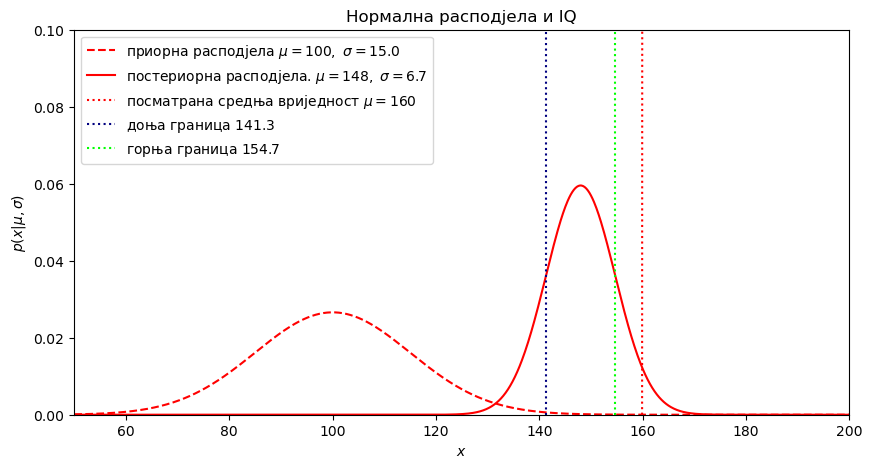

In [2]:
sv = [15, 6.7, 1] # приорна ширина IQ расподјеле укљученаж
linestyles = ['--', '-', ':']
mv = [100, 148, 160] # приорна средња вриједност IQ расподјеле укључена
labeltext = ['приорна расподјела', 
             'постериорна расподјела.', 
             'посматрана средња вриједност']

xplot = np.linspace(50, 200, 1000)
fig, ax = plt.subplots(figsize=(10, 5))

for sigma, ls, mu, lab in zip(sv, 
                              linestyles, 
                              mv, 
                              labeltext):

    dist = norm(mu, sigma) # гаусијанска расподјела
    if sigma > 1:
        plt.plot(xplot, dist.pdf(xplot), 
                 ls=ls, c='red',
                 label=r'%s $\mu=%i,\ \sigma=%.1f$' % (lab, mu, sigma))
    else:
        plt.plot([159.9, 160.1], [0, 0.8], 
                 ls=ls, color='red', label=r'%s $\mu=%i$' % (lab, mu))
        
plt.axvline(141.3, linestyle=':', color='navy', label=r'доња граница $141.3$')
plt.axvline(154.7, linestyle=':', color='lime', label=r'горња граница $154.7$')
plt.xlim(50, 200)
plt.ylim(0, 0.1)
plt.xlabel('$x$')
plt.ylabel(r'$p(x|\mu,\sigma)$')
plt.title('Нормална расподјела и IQ')
plt.legend()
plt.show()

Ваља размислити о томе како би фреквентиста мјерио IQ, и колики би тек хаос настао кад је

потребно анализирати више параметара одједном.

---

### Процјена максималне вјеродостојности

<hr style="border: none; height: 2px; background-color: red; opacity: 0.5;" />

Максимална вјеродостојност је релевантна за фреквентистичку и бајесовску слику.

Приступ одређивања МВ се састоји из неколико корака.

1. Формулација модела/хипотезе о томе како је неки скуп података генерисан: $M(\theta)$;

2. Потрага за најбољим параметрима модела ($\theta$), који максимизују $L(\theta)=p(D|M)$,

што је заправо максимизација вјероватноће, и добијају се процјене $\theta^0$;

3. Одређивање неодређености процјене. Тражи се ниво повјерења за $\theta^0$, аналитички или

нумерички, разним техникама (*bootstrap*, *jackknife*, *cross-validation*);

4. Тестирање хипотезе. Доносе се закључци о моделима и неодређеностима.

---

Примјера ради, ако су подаци генерисани гаусовским процесом, са средњом вриједношћу $\mu$

и стандардним одступањем $\sigma$, густина вјероватноће за неку вриједност $x$ је:

$$
p(x\,|\,\mu,\sigma)=\frac{1}{\sigma\sqrt{2\pi}}e^{\frac{-(x-\mu)^2}{2\sigma^2}}.
$$

Ако је пак, потребно израчунати тоталну вјероватноћу за читав скуп података, онда се рачуна

производ свих појединачних вјероватноћа:

$$
L\equiv p(\{x_i\}|M(\theta))=\prod_{i=1}^Np(x_i|M(\theta)),
$$

гдје се $\theta$ односи на $k$ параметара модела, који може бити вишедимензионалан. $L(\{x_i\})$ би

се могло протумачити као вјероватноћа за скуп података, уз дате параметре модела, а $L(\theta)$ је

вјероватноћа за параметре модела, уз дате податке. Овај прелаз је јако важан. $L$ пишемо као:

$$
L = \prod_{i=1}^{N} \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{(x_i - \mu)^2}{2\sigma^2}}\implies L = \left( \prod_{i=1}^{N} \frac{1}{\sigma \sqrt{2\pi}} \right) e^{-\frac{1}{2} \sum \left( \frac{(x_i - \mu)}{\sigma} \right)^2},
$$

гдје је аргумент експоненцијала $e^{-\frac{\chi^2}{2}}$ ($\chi^2$ анализа , нпр. из методе најмањих квадрата). 

За гаусовску расподјелу важи:

$$
\chi^2 = \sum_{i=1}^{N} \left( \frac{x_i - \mu}{\sigma} \right)^2.
$$

Дакле, за гаусовске расподјеле, максимизовање вјероватноће (највеће вјеродостојности) или 

логаритамске вјероватноће је исто што и минимизовање $\chi^2$. Ово има везе и са ЦГТ.

---

Као примјер максимизовања функције вјеродостојности за негаусовску расподјелу, можемо

користити Поасонову расподјелу. У том случају, важи:

$$
p(x_i|\mu) = \frac{e^{-\mu} \mu^{x_i}}{x_i!}
$$

гдје је $\mu$ просјечан број догађаја, $N$ је број посматраних догађаја, а $\{x_i\}$ измјерени

подаци. Функција вјеродостојности се пише као:

$$
L \equiv p(\{x_i\} | \mu) = \prod_{i=1}^{N} \frac{e^{-\mu} \mu^{x_i}}{x_i!},
$$

а логаритам те функције као:

$$
\ln L = \sum_{i=1}^{N} \ln\left( \frac{e^{-\mu} \mu^{x_i}}{x_i!} \right)= \sum_{i=1}^{N} \left( -\mu + x_i \ln(\mu) - \ln(x_i!) \right)
$$

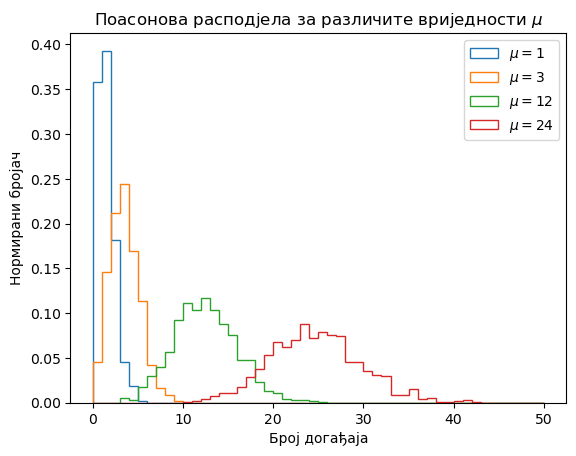

In [3]:
kpts=np.arange(0,50)
for mu, c in zip([1,3,12, 24], sns.color_palette()[:4]):
    randomVariates = poisson.rvs(mu, size=1000)
    plt.hist(randomVariates, density=True, color=c, histtype='step', 
             bins=np.arange(0,51), label='$\mu=' + str(mu) + '$')

plt.legend()
plt.title(r'Поасонова расподјела за различите вриједности $\mu$')
plt.xlabel('Број догађаја')
plt.ylabel('Нормирани бројач')
plt.show()

Највјероватнија вриједност за μ: 13.9899


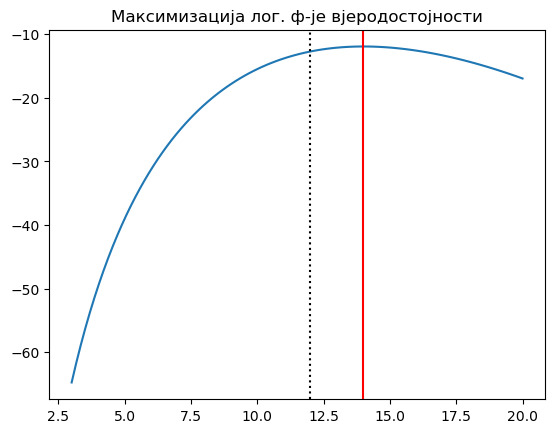

In [4]:
poisson_data = poisson.rvs(12, size=5) # генерисање случајних бројева
mu_proposed = np.linspace(3,20,100) # треба наћи μ које максимизује лог. ф-је вјеродостојности

lnL_scan = []
for mu in mu_proposed: # по узору на формуле из теорије
    lnL_temp = poisson.logpmf(poisson_data, mu=mu) 
    lnL_temp = np.sum(lnL_temp) 
    lnL_scan.append( lnL_temp )

lnL_scan = np.array(lnL_scan)
plt.plot(mu_proposed,lnL_scan)
findmax = mu_proposed[np.argmax(lnL_scan)]
print('Највјероватнија вриједност за μ:', np.round(findmax,4))
plt.axvline(findmax, c='red')
plt.axvline(12, c='black',ls='dotted')
plt.title('Максимизација лог. ф-је вјеродостојности')
plt.show()

За Поасонову расподјелу, можемо максимизовати логаритамску функцију вјеродостојности

аналитички:

$$
\frac{\partial L(\mu)}{\partial \mu} = \frac{\partial}{\partial \mu} \left( \sum_{i=1}^{N} \Big( -\mu + x_i \ln(\mu)\Big) \right),
$$

$$
0 = \sum_{i=1}^{N} \left( -1 + \frac{x_i}{\mu} \right) \implies\hat{\mu} = \frac{1}{N} \sum_{i=1}^{N} x_i.
$$

### Фитовање - разно

<hr style="border: none; height: 2px; background-color: red; opacity: 0.5;" />

Степени закони $y\propto x^{\alpha}$ (који су чести у астрофизици) постају линеарне зависности на $\log-\log$ скали,

тј. $\ln{y}\propto\alpha\ln{x}+C$, те је фитовање података линијом доста заступљено.


Претпоставимо да је шум у нашем мјерењу генерисан неким гаусовским процесом $y_i=ax_i+b+r_i$, 

гдје је $r_i$ извучено из $\mathcal{N}(0,\sigma)$, а $\sigma$ је наравно мјера неодређености (иста за сваки податак). 

Постоје параметри $a$ и $b$, те важи да је модел $M(a,b)$. Рачунамо функцију вјеродостојности као:

$$
p(y_i|x_i, M(a,b), \sigma) = \mathcal{N}(y_i - M(x)|\sigma) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{(y_i - M(x_i))^2}{2\sigma^2}},
$$

$$
\ln L(a, b) = C - \frac{1}{2} \sum_{i=1}^{N} \frac{(y_i - M(x_i))^2}{\sigma^2} =C - \frac{1}{2} \chi^2.
$$

Ако се претпостави да грешке имају нормалну расподјелу, онда максимизовање $L$ води до истог рјешења

као и минимизација $χ²$, тј. метода најмањих квадрата. Ово је битно за наставак!

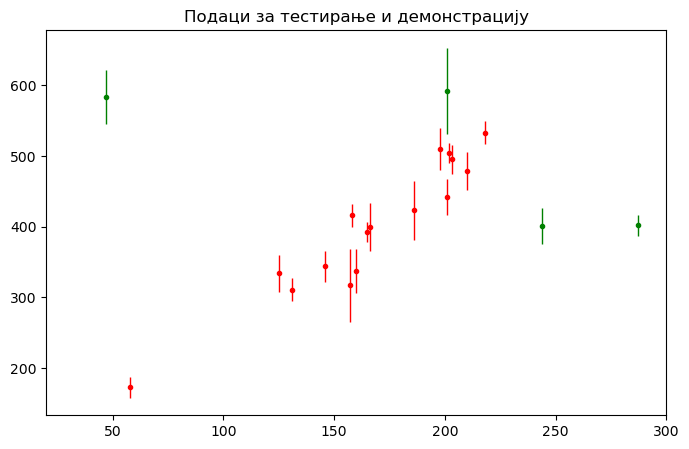

In [5]:
data = fetch_hogg2010test() # подаци који садрже и одступања
x = data['x'] 
y = data['y'] 
dy = data['sigma_y'] # неодређености 

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)

ax.errorbar(x[4:], y[4:], dy[4:], # мало друкчији начин записа визуализације
            fmt='.', lw=1, c='red')
ax.errorbar(x[:4], y[:4], dy[:4], 
            fmt='.', lw=1, c='green');
ax.set_xlim(20,300)
plt.title('Подаци за тестирање и демонстрацију')
plt.show()

In [6]:
def squared_loss(m, b, x, y, dy): # стандардна функција "квадратног губитка" (chi²)
    y_fit = m * x + b
    return np.sum(((y - y_fit) / dy) ** 2, -1)

f_squared = lambda beta: squared_loss(beta[0], beta[1], # функција која дефинише суму квад. губитака
                                      x=x[4:], y=y[4:], # искључујемо прва четири елемента (могућа одступања)
                                      dy=dy[4:])
beta0 = (1, 30) # иницијалне пп. вриједности за нагиб и пресјек
beta_squared = optimize.fmin(f_squared, beta0) # траже се вриједности бета које минимизују суму квад. губиатака

Optimization terminated successfully.
         Current function value: 18.680770
         Iterations: 53
         Function evaluations: 106


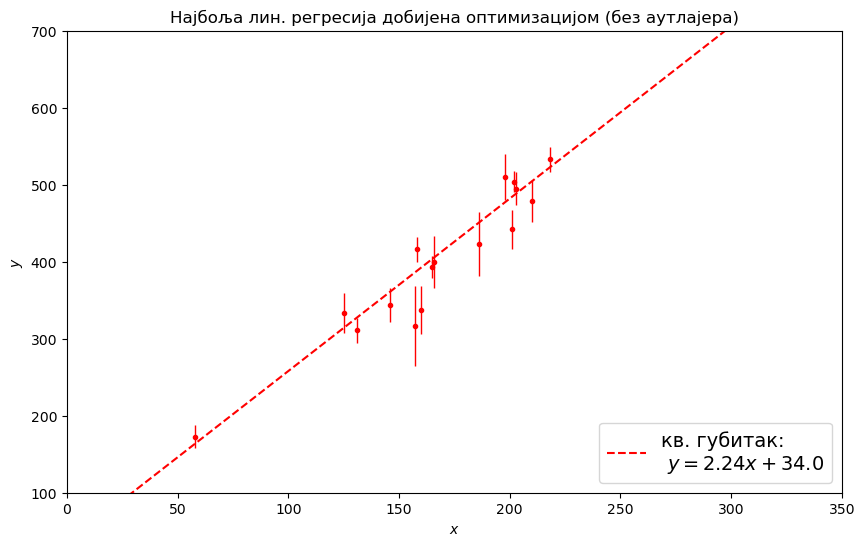

In [7]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

ax.errorbar(x[4:], y[4:], dy[4:], 
            fmt='.', lw=1, c='red')
x_fit = np.linspace(0, 350, 10)
ax.plot(x_fit, beta_squared[0] * x_fit + beta_squared[1], 
        ls='--', color='red',
        label="кв. губитак:\n $y=%.2fx + %.1f$" % tuple(beta_squared))

ax.set_xlim(0, 350)
ax.set_ylim(100, 700)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.legend(loc=4, prop=dict(size=14))
plt.title('Најбоља лин. регресија добијена оптимизацијом (без аутлајера)')
plt.show()

Сад можемо пробати да "контаминирамо" фит, користећи и елементе који садрже одступања!

In [8]:
f_squared = lambda beta: squared_loss(beta[0], beta[1], 
                                      x=x, y=y, 
                                      dy=dy)
beta0 = (1, 30) 
beta_squared_outlier = optimize.fmin(f_squared, beta0)

Optimization terminated successfully.
         Current function value: 289.963723
         Iterations: 70
         Function evaluations: 133


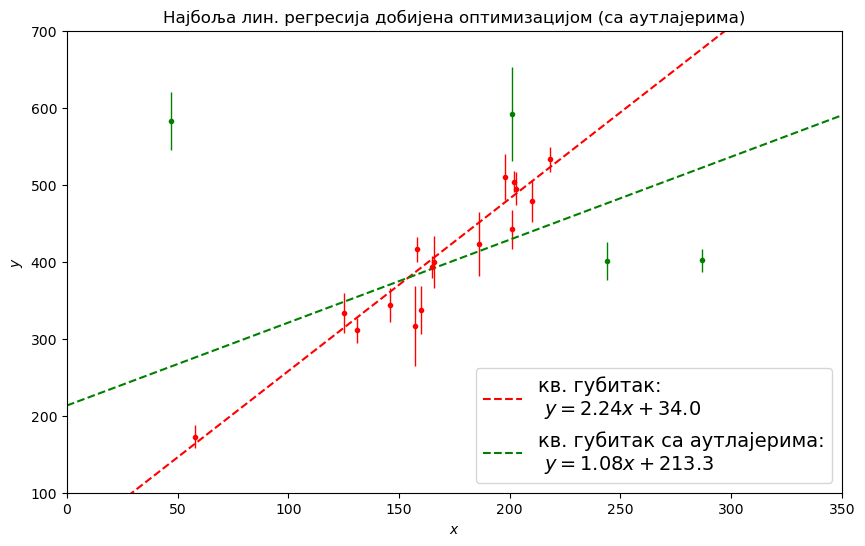

In [9]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

ax.errorbar(x[4:], y[4:], dy[4:], 
            fmt='.', lw=1, c='red')

ax.errorbar(x[:4], y[:4], dy[:4], 
            fmt='.', lw=1, c='green'); # аутлајери

x_fit = np.linspace(0, 350, 10)
ax.plot(x_fit, beta_squared[0] * x_fit + beta_squared[1], 
        ls='--', color='red',
        label="кв. губитак:\n $y=%.2fx + %.1f$" % tuple(beta_squared))

ax.plot(x_fit, beta_squared_outlier[0]*x_fit + beta_squared_outlier[1], # укључени аутлајери
        ls='--', color='green',
        label="кв. губитак са аутлајерима:\n $y=%.2fx + %.1f$" % tuple(beta_squared_outlier))

ax.set_xlim(0, 350)
ax.set_ylim(100, 700)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.legend(loc=4, prop=dict(size=14))

plt.title('Најбоља лин. регресија добијена оптимизацијом (са аутлајерима)')
plt.show()

Фит сада изгледа јако лоше и треба га поправити. Формула $\chi^2=\sum_{i=1}^N(y_i-M(x_i))^2/\sigma^2 $ једноставно

је осјетљива на издвојене вриједности. Стандардан приступ је употреба $\text{Huber loss}$ функције:

$$
\sum_{i=1}^Ne(y_i|y),\quad e(t)= \begin{cases} 
\dfrac{1}{2} \, t^2, & \text{ако } |t|\le c, \\
c\,|t|\;-\;\dfrac{1}{2}\,c^2, & \text{ако } |t| > c,
\end{cases},\quad t = \dfrac{\bigl|\,y - M(x)\bigr|}{\sigma}.
$$

Углавном, јако је битно какав је модел, тј. параметри модела. Ако су параметри модела лоши, онда ће 

и фит бити лош. Напомена, овдје је заправо само урађена манипулација са $L$ функцијом!

In [10]:
def huber_loss(m, b, x, y, dy, c=1): # експериментисати са вриједностима од c
    y_fit = m * x + b 
    t = abs((y - y_fit) / dy) 
    mask = t > c 
    
    return np.sum(np.logical_not(mask) * (0.5 * t ** 2) - \
                  (mask) * c * (0.5 * c - t), -1)

f_huber = lambda beta: huber_loss(beta[0], beta[1], 
                                  x=x, y=y, dy=dy, c=1)

beta0 = (1, 30)
beta_huber = optimize.fmin(f_huber, beta0)

Optimization terminated successfully.
         Current function value: 43.439758
         Iterations: 62
         Function evaluations: 118


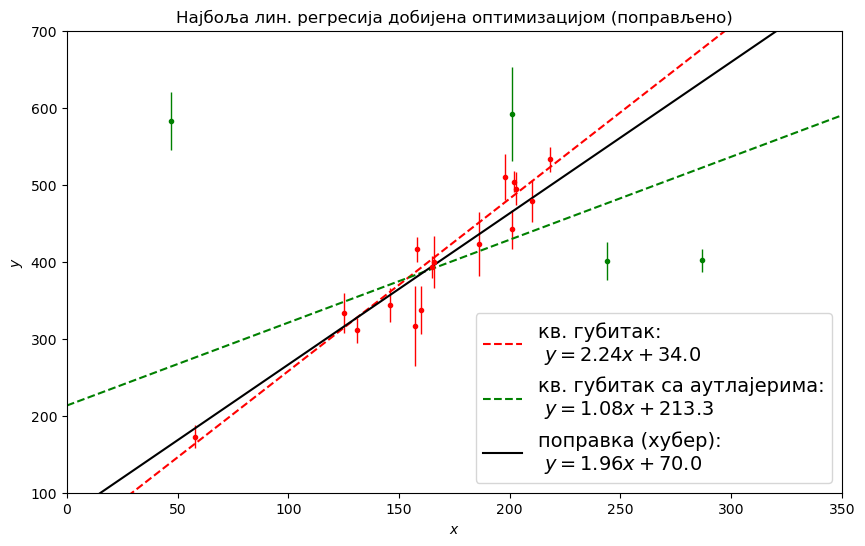

In [11]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

ax.errorbar(x[4:], y[4:], dy[4:], 
            fmt='.', lw=1, c='red')
ax.errorbar(x[:4], y[:4], dy[:4], 
            fmt='.', lw=1, c='green')

x_fit = np.linspace(0, 350, 10)
ax.plot(x_fit, beta_squared[0] * x_fit + beta_squared[1], 
        ls='--', color='red',
        label="кв. губитак:\n $y=%.2fx + %.1f$" % tuple(beta_squared))

ax.plot(x_fit, beta_squared_outlier[0] * x_fit + beta_squared_outlier[1], 
        ls='--', color='green',
        label="кв. губитак са аутлајерима:\n $y=%.2fx + %.1f$" % tuple(beta_squared_outlier))

ax.plot(x_fit, beta_huber[0] * x_fit + beta_huber[1], # аутлајерима је сада дата мања "отежењеност"
        ls='-', color='black',
        label="поправка (хубер):\n $y=%.2fx + %.1f$" % tuple(beta_huber))

ax.set_xlim(0, 350)
ax.set_ylim(100, 700)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.legend(loc=4, prop=dict(size=14))

plt.title('Најбоља лин. регресија добијена оптимизацијом (поправљено)')
plt.show()

In [12]:
N = x[4:].shape[0] # без аутлајера
N_outlier = x.shape[0] # са аутлајерима
k = 2  # број параметара модела (a,b)

chi2 = squared_loss(beta_squared[0], 
                    beta_squared[1], 
                    x=x[4:], y=y[4:], dy=dy[4:])
chi2dof = chi2 / (N-k) # дефинисаћемо испод, још једном!

chi2_outlier = squared_loss(beta_squared_outlier[0], 
                            beta_squared_outlier[1], 
                            x=x, y=y, dy=dy)
chi2dof_outlier = chi2_outlier / (N_outlier - k)

found =  chi2dof-1
expected = np.sqrt(2/(N-k))
print("Без аутлајера chi2dof-1:", found, "std:", expected, "Nsigma:", found/expected)

found =  chi2dof_outlier-1
expected = np.sqrt(2/(N_outlier-k))
print("Са аутлајерима chi2dof-1:", found, "std:", expected, "Nsigma:", found/expected)

Без аутлајера chi2dof-1: 0.33434070794594706 std: 0.3779644730092272 Nsigma: 0.8845823663902529
Са аутлајерима chi2dof-1: 15.109095710111468 std: 0.3333333333333333 Nsigma: 45.327287130334405


### Процјена тачности фита & упоређивање модела

<hr style="border: none; height: 2px; background-color: red; opacity: 0.5;" />

У случају да имамо $N$ података/координата извучених из линеарне расподјеле, можемо фитовати са 

полиномом реда $N-1$, и то скоро перфектно, али ово не помаже при предвиђању будућих мјерења.

За гаусовске расподјеле, рачуна се параметар $z_i=(x_i-\mu)/\sigma$, па онда:

$$
\ln{L}=C-\frac{1}{2}\sum_{i=1}^Nz^2_i=C-\frac{1}{2}\chi^2.
$$

Дакле, за гаусовске неодређености, $L$ прати расподјелу $\chi^2$.

Средња вриједност $\chi^2$ расподјеле је $N-k$, а стандардна девијација је $\sqrt{2(N-k)}$. Може

се дефинисати $\chi^2$ по степену слободе, или $\chi^2_{\text{dof}}$, као:

$$
\chi^2_{\text{dof}}=\frac{1}{N-k}\sum_{i=1}^Nz^2_i,
$$

гдје је $k$ број параметара модела, извучених из података. У случају да имамо добар фит, очекујемо

да је $\chi^2_{\text{dof}}\approx1$. Ако важи $\chi^2_{\text{dof}}\gg1$, онда се користи погрешно моделовање. 

У зависности од тога да ли су неодређености у подацима **пот(пре)цијењене**, ово води до

**ниских(високих)** вриједности $\chi^2_{\text{dof}}$. Испод је дат примјер који ово добро показује. 

Ради се о низу посматрања луминозности звијезде, са познатим грешкама.

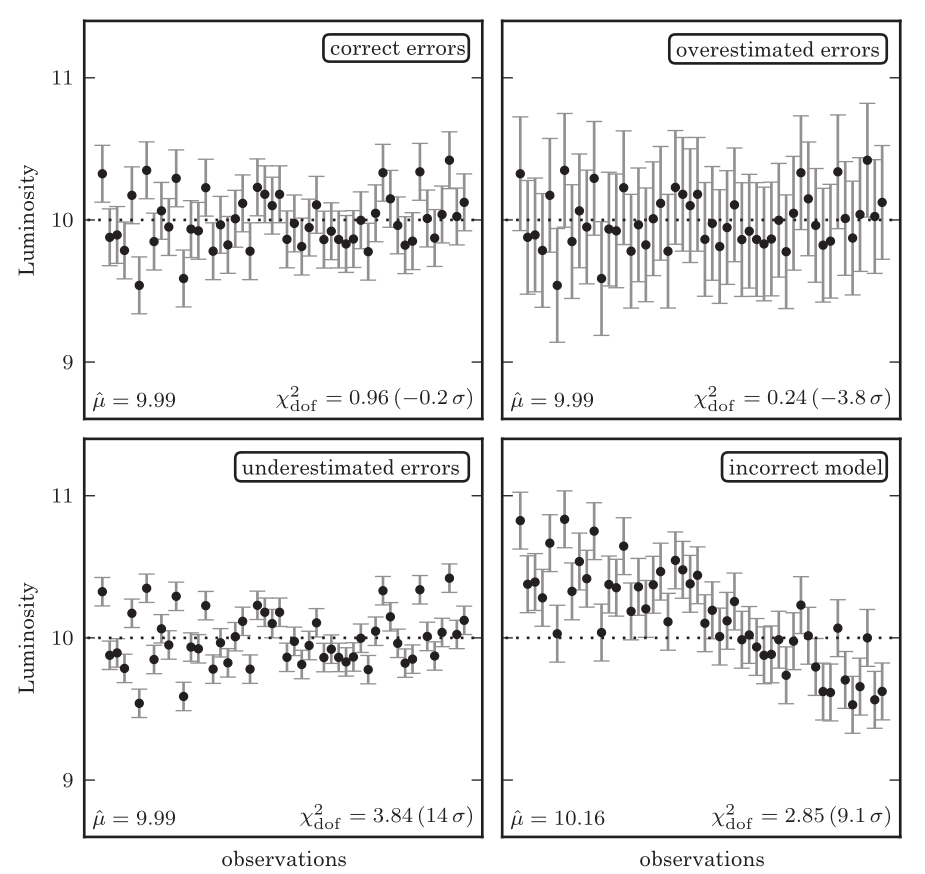

In [13]:
lnL_sq = - squared_loss(beta_squared_outlier[0], beta_squared_outlier[1], 
                        x=x, y=y, dy=dy)

lnL_huber = - huber_loss(beta_huber[0], beta_huber[1], 
                         x=x, y=y, dy=dy)

print('Максимална лог. вјеродостојност за квадратни губитак је: %.1f' % lnL_sq)
print('Максимална лог. вјеродостојност за хуберов губитак је: %.1f' % lnL_huber)

Максимална лог. вјеродостојност за квадратни губитак је: -290.0
Максимална лог. вјеродостојност за хуберов губитак је: -43.4


---
Ако се упоређују модели са различитим бројем параметара, потребан је друкчији приступ.

У виду треба имати комплексност модела, и ефективно пенализовање/ограничавање модела са

додатним параметрима (који нису омеђени самим подацима). Користи се метода *Akaike*

*Information Criterion (AIC)*, дата преко:


$$
\text{AIC}_M\equiv-2\ln{[L^0(M)]}+2k+\frac{2k(k+1)}{N-k-1},
$$

гдје је $k$ број параметара модела, а $N$ број података. За гаусовске расподјеле,

први члан у једначини је једнак $\chi^2$. Модел са најмањом вриједношћу *AIC* је

најпожељнији. У случају да су неки модели једнако добри у фитовању података (нпр.

једнаке $L^0$ вриједности), онда други и трећи члан у једначини заправо пенализују 

комплексност, тако да бива фаворизован модел са мањим бројем параметара. *AIC*

је само апроксимативна метода, за брзу процјену тачности фита.

---

### Одређивање нивоа повјерења - *Bootstrap*

<hr style="border: none; height: 2px; background-color: red; opacity: 0.5;" />

Често се претпоставља да су расподјеле гаусовске, а узорци велики. Чак и кад то није 

тачно, постоје технике реузорковања, које омогућавају да одредимо границе повјерења

и неодређености код мјерених параметара модела. За подсјећање, имамо сет података 

$\{x_i\}$, из којих је процијењена расподјела $f(x)$ за истиниту расподјелу $h(x)$.

*Bootstrap* метода је суштински насумично бирање података из оригиналне групе података,

више пута, са враћањем, а из узорака се рачуна статистика. Узорковањем из $N$ података,

постоји $N!$ различитих група, а шанса да се добије баш оригинална група је $N!/N^N$ 

(нпр. за $N=10$, та шанса је $0.00036$). Испод је примјер. Узима се хиљаду бројева

из нормалне расподјеле. Из тог скупа се бира исти број елемената као што их има у

оригиналу (уз дозвољено понављање) -*bootstrap* узорак. Ово се ради много пута...

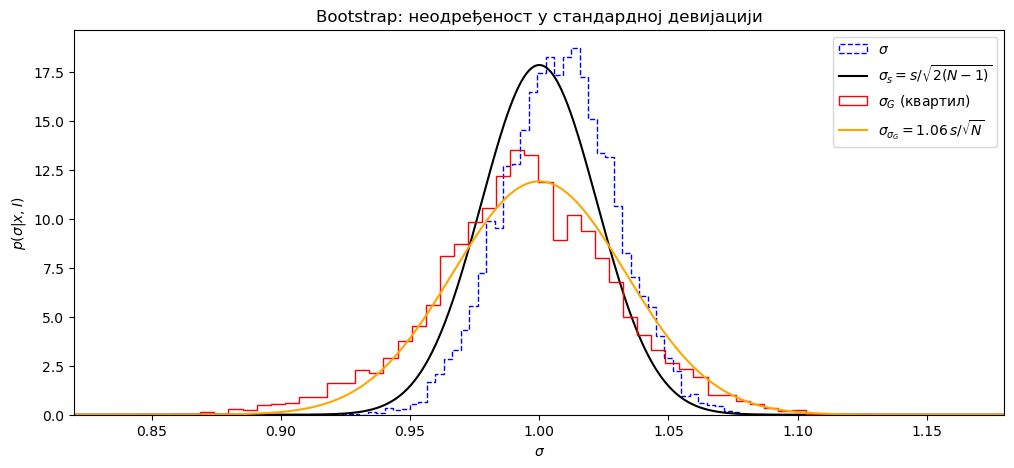

In [108]:
m = 1000  # број података
n = 10000  # bootstraps 

np.random.seed(11) # узорковање из нормалне расподјеле
data = norm(0, 1).rvs(m)
mu1_bootstrap = bootstrap(data, n, np.std,  # реузорковање
                          kwargs=dict(axis=1, ddof=1))
mu2_bootstrap = bootstrap(data, n, sigmaG, # квартили
                          kwargs=dict(axis=1))

xgrid = np.linspace(0.8, 1.2, 1000)
sigma1 = 1. / np.sqrt(2 * (m - 1))
pdf1 = norm(1, sigma1).pdf(xgrid)
sigma2 = 1.06 / np.sqrt(m)
pdf2 = norm(1, sigma2).pdf(xgrid)

plt.figure(figsize=(12,5))
plt.hist(mu1_bootstrap, bins=50, density=True, 
        histtype='step', color='blue', ls='dashed', 
        label=r'$\sigma$')
plt.plot(xgrid, pdf1, color='black', label=r'$\sigma_s=s/\sqrt{2(N-1)}$')

plt.hist(mu2_bootstrap, bins=50, density=True, 
        histtype='step', color='red', 
        label=r'$\sigma_G$ (квартил)')
plt.plot(xgrid, pdf2, color='orange', label=r'$\sigma_{\sigma_G}=1.06\,s/\sqrt{N}$')

plt.xlim(0.82, 1.18)
plt.xlabel(r'$\sigma$')
plt.ylabel(r'$p(\sigma|x,I)$')
plt.legend()
plt.title('Bootstrap: неодређеност у стандардној девијацији')
plt.show()

### Одређивање нивоа повјерења - *Jackknife*

<hr style="border: none; height: 2px; background-color: red; opacity: 0.5;" />

Ова метода је слична претходној, али се сада, при прављењу новог скупа, сваки пут изостави

један или више података. Реузорковање се такође врши много пута. Изостављањем једног 

податка сваки пут, прави се $N$ скупова са $N-1$ података. За неку статистику $\alpha$, важи:

$$
\alpha^J = \alpha_N + \Delta\alpha,
$$

гдје је $\alpha_N$ статистика израчуната на оригиналном скупу података, и:

$$
\Delta\alpha = (N - 1) \left( \alpha_N - \frac{1}{N} \sum_{i=1}^{N} \alpha_i^* \right),
$$

гдје је $\{\alpha_i^*\}$ скуп статистика израчунатих на $N$ скупова података.

Стандардна девијација код ове методе дата је преко:

$$
\sigma_\alpha = \sqrt{\frac{1}{N(N - 1)} \sum_{i=1}^{N} \left[ N \alpha_N - \alpha^J - (N - 1)\alpha_i^* \right]^2}.
$$

Границе нивоа повјерења за $\alpha$ могу бити израчунате користећи Студентову $t$ расподјелу,

уз $t = (\alpha - \alpha^J)/\sigma_\alpha$ и $(N - 1)$ степени слободе.

1.0015366861435233 0.02228013942047898
0.597747861971019 0.031353107946452324
μ₁ средње: 1.00 +- 0.02
μ₁ средње: 0.60 +- 0.03


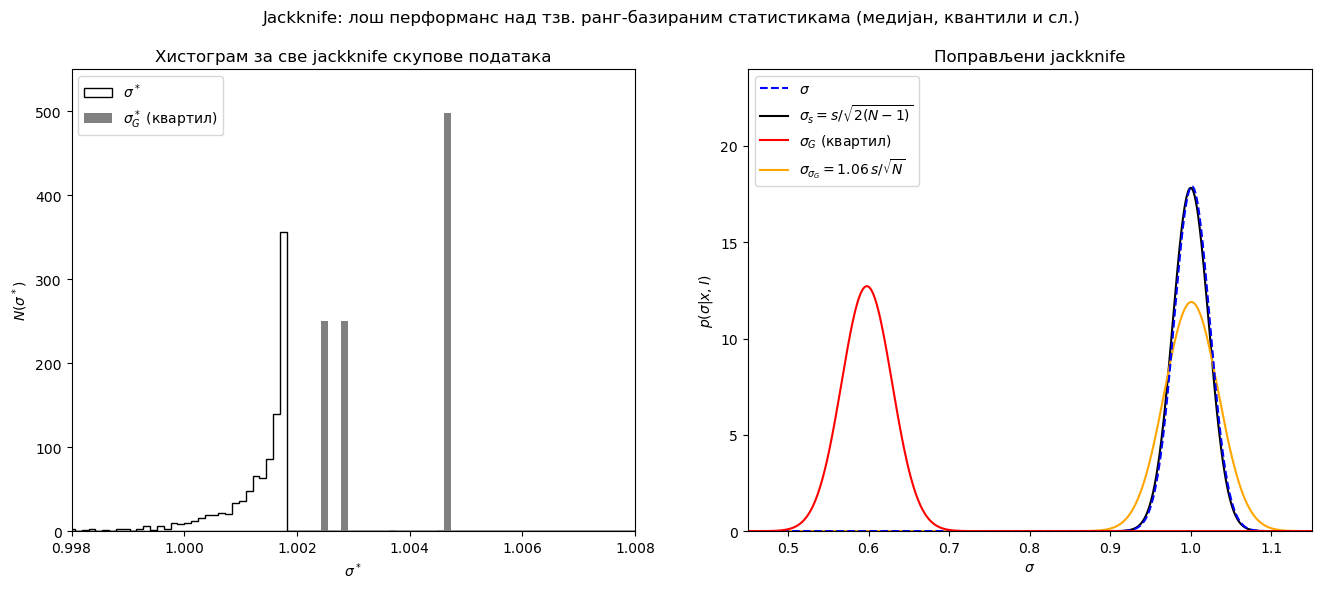

In [116]:
m = 1000  
n = 10000  

np.random.seed(123)
data = norm(0, 1).rvs(m)

# просјечна вриједност Jackknife процјена ст. девијације, њена ст. девијација и појединачне Jackknife вриједности 
mu1, sigma_mu1, mu1_raw = jackknife(data, np.std, kwargs=dict(axis=1, ddof=1), return_raw_distribution=True)
pdf1_theory = norm(1, 1. / np.sqrt(2 * (m - 1)))
pdf1_jackknife = norm(mu1, sigma_mu1)
print(mu1, sigma_mu1)

# Jackknife процјена за робусне мјере ширења (поново квартили) итд.
mu2, sigma_mu2, mu2_raw = jackknife(data, sigmaG, kwargs=dict(axis=1), return_raw_distribution=True)
pdf2_theory = norm(data.std(), 1.06 / np.sqrt(m))
pdf2_jackknife = norm(mu2, sigma_mu2)
print(mu2, sigma_mu2)

print('μ₁ средње: %.2f +- %.2f' % (mu1, sigma_mu1))
print('μ₁ средње: %.2f +- %.2f' % (mu2, sigma_mu2))

fig = plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.hist(mu1_raw, np.linspace(0.996, 1.008, 100),
        label=r'$\sigma^*$',
        histtype='stepfilled', fc='white', 
        ec='black', density=False)
plt.hist(mu2_raw, np.linspace(0.996, 1.008, 100),
        label=r'$\sigma_G^*$ (квартил)',
        histtype='stepfilled', fc='gray', 
        density=False)
plt.legend(loc='upper left', handlelength=2)
plt.xlabel(r'$\sigma^*$')
plt.ylabel(r'$N(\sigma^*)$')
plt.xlim(0.998, 1.008)
plt.ylim(0, 550)
plt.title('Хистограм за све jackknife скупове података')

plt.subplot(122)
x = np.linspace(0.45, 1.15, 1000)
plt.plot(x, pdf1_jackknife.pdf(x), color='blue', ls='dashed', label=r'$\sigma$', zorder=2)
plt.plot(x, pdf1_theory.pdf(x), color='black', label=r'$\sigma_s=s/\sqrt{2(N-1)}$', zorder=1)
plt.plot(x, pdf2_jackknife.pdf(x), color='red', label=r'$\sigma_G$ (квартил)', zorder=2)
plt.plot(x, pdf2_theory.pdf(x), color='orange', label=r'$\sigma_{\sigma_G}=1.06\,s/\sqrt{N}$', zorder=1)
plt.legend(loc='upper left', handlelength=2)
plt.xlabel(r'$\sigma$')
plt.ylabel(r'$p(\sigma|x,I)$')
plt.xlim(0.45, 1.15)
plt.ylim(0, 24)
plt.title('Поправљени jackknife')

plt.suptitle('Jackknife: лош перформанс над тзв. ранг-базираним статистикама (медијан, квантили и сл.)')
plt.show()

Jackknife је лакше примјењивати кад су у питању комплексне шеме узорковања. 

Bootstrap метода је надмоћнија што се тиче рачунања интервала повјерења.

Препоручљиво је користити обје методе симултано.